In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
maindir = "D:/Blood/data" # Directory with files
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [104]:
# Define target columns
target_columns = ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']

# Separate features and targets
X_train = train.drop(columns=target_columns+['Reading_ID'])
y_train = train[target_columns]

X_test = test

In [105]:
from sklearn.preprocessing import LabelEncoder

# Initialize dictionary to store LabelEncoders for each target
encoders = {}

# Iterate over each target column and encode
for col in target_columns:
    encoder = LabelEncoder()
    y_train[col] = encoder.fit_transform(y_train[col]) 
    encoders[col] = encoder

# Verify encoding
print("Encoding completed for all target columns.")
for col, encoder in encoders.items():
    print(f"Target: {col}, Classes: {list(encoder.classes_)}")


Encoding completed for all target columns.
Target: hdl_cholesterol_human, Classes: ['high', 'low', 'ok']
Target: hemoglobin(hgb)_human, Classes: ['high', 'low', 'ok']
Target: cholesterol_ldl_human, Classes: ['high', 'low', 'ok']


In [106]:
y_train_target1 = y_train.iloc[:, 0]
y_train_target2 = y_train.iloc[:, 1]
y_train_target3 = y_train.iloc[:, 2]  

In [107]:
# Drop specific non-relevant columns
X_test = X_test.drop(columns=['id', 'std', 'Reading_ID'], errors='ignore')
X_test_encode = X_test.copy().drop(columns = ['donation_id'])

In [108]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Parameters
input_dim = X_train.shape[1]
encoding_dim = 20  # Adjust based on dimensionality reduction requirements

# Autoencoder Model
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)  # Separate encoder for feature extraction

# Compile and Train Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Extract Features
X_train_autoencoded = encoder.predict(X_train)
X_test_autoencoded = encoder.predict(X_test_encode)

# Updated Features
print("Original Shape:", X_train.shape)
print("Reduced Shape:", X_train_autoencoded.shape)


Epoch 1/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0552 - val_loss: 0.2591
Epoch 2/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2298 - val_loss: 0.0936
Epoch 3/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0655 - val_loss: 0.0234
Epoch 4/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224 - val_loss: 0.0198
Epoch 5/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0172
Epoch 6/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0148
Epoch 7/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0124
Epoch 8/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0119 - val_loss: 0.0105
Epoch 9/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 10/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - val_loss: 0.0048
Epoch 11/100
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 12/100
329/329 ━━━━━━━━━━━━━━━━━━━━

In [13]:
# Replace original features with autoencoded features
X_train = pd.DataFrame(X_train_autoencoded, index=X_train.index)
X_test = pd.DataFrame(X_test_autoencoded, index=X_test.index)

print("Updated Train Shape:", X_train.shape)
print("Updated Test Shape:", X_test.shape)


Updated Train Shape: (13140, 20)
Updated Test Shape: (3660, 20)


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define separate models for each target
models = {
    "Target1": RandomForestClassifier(random_state=42),
    "Target2": RandomForestClassifier(random_state=42),
    "Target3": RandomForestClassifier(random_state=42),
}

# Train models and store results
trained_models = {}
for i, (target_name, y_target) in enumerate(
    zip(["Target1", "Target2", "Target3"], [y_train_target1, y_train_target2, y_train_target3])
):
    print(f"Training model for {target_name}..")
    model = models[target_name]
    model.fit(X_train_autoencoded, y_target)
    trained_models[target_name] = model
    print(f"Model for {target_name} trained.")

print("All models trained.")


Training model for Target1...
Model for Target1 trained.
Training model for Target2...
Model for Target2 trained.
Training model for Target3...
Model for Target3 trained.
All models trained.


In [120]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

# Perform Stratified K-Fold cross-validation for each target
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

validation_results = {}
for i, (target_name, y_target) in enumerate(
    zip(["Target1", "Target2", "Target3"], [y_train_target1, y_train_target2, y_train_target3])
):
    print(f"\nValidating model for {target_name}...")
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_autoencoded, y_target)):
        X_train_fold, X_val_fold = X_train_autoencoded[train_idx], X_train_autoencoded[val_idx]
        y_train_fold, y_val_fold = y_target.iloc[train_idx], y_target.iloc[val_idx]

        # Train model
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train_fold, y_train_fold)

        # Validate model
        y_val_pred = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, y_val_pred)
        fold_accuracies.append(acc)

        print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

    validation_results[target_name] = fold_accuracies
    print(f"Average Accuracy for {target_name}: {sum(fold_accuracies) / len(fold_accuracies):.4f}")

     # Train final model on the entire training dataset
    final_model = RandomForestClassifier(random_state=42)
    final_model.fit(X_train_autoencoded, y_target)

    # Predict on the test dataset
    test_pred = final_model.predict(X_test_autoencoded)
    test_predictions[target_name] = test_pred

# Print test predictions shape for each target
for target_name, predictions in test_predictions.items():
    print(f"Test Predictions for {target_name}: {predictions.shape}")


Validating model for Target1...
Fold 1 Accuracy: 0.8238
Fold 2 Accuracy: 0.8314
Fold 3 Accuracy: 0.8349
Fold 4 Accuracy: 0.8196
Fold 5 Accuracy: 0.8288
Average Accuracy for Target1: 0.8277

Validating model for Target2...
Fold 1 Accuracy: 0.9502
Fold 2 Accuracy: 0.9456
Fold 3 Accuracy: 0.9513
Fold 4 Accuracy: 0.9490
Fold 5 Accuracy: 0.9490
Average Accuracy for Target2: 0.9490

Validating model for Target3...
Fold 1 Accuracy: 0.8413
Fold 2 Accuracy: 0.8360
Fold 3 Accuracy: 0.8573
Fold 4 Accuracy: 0.8371
Fold 5 Accuracy: 0.8474
Average Accuracy for Target3: 0.8438
Test Predictions for Target1: (3660,)
Test Predictions for Target2: (3660,)
Test Predictions for Target3: (3660,)


In [123]:
decoding_map = {'Target1': {0:'ok', 1:'low', 2:'high'},
'Target2': {0:'ok', 1:'low', 2:'high'},
'Target3': {0:'ok', 1:'low', 2:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [124]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["Target1"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["Target2"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["Target3"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_baseline_autoenc.csv", index=False)


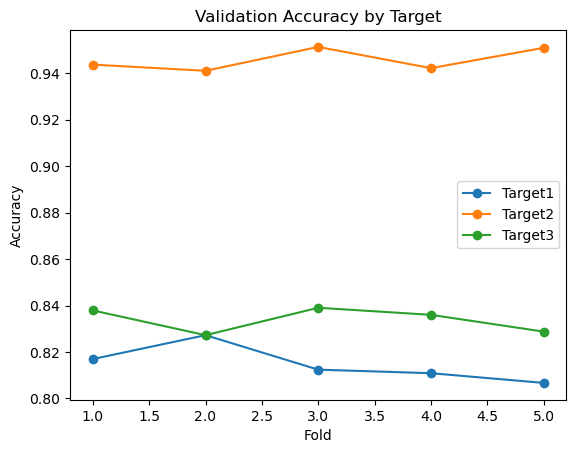

In [17]:
import matplotlib.pyplot as plt

# Visualize accuracy for each target
for target_name, accuracies in validation_results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=target_name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy by Target")
plt.legend()
plt.show()


In [21]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

SHAP Summary for Class 0


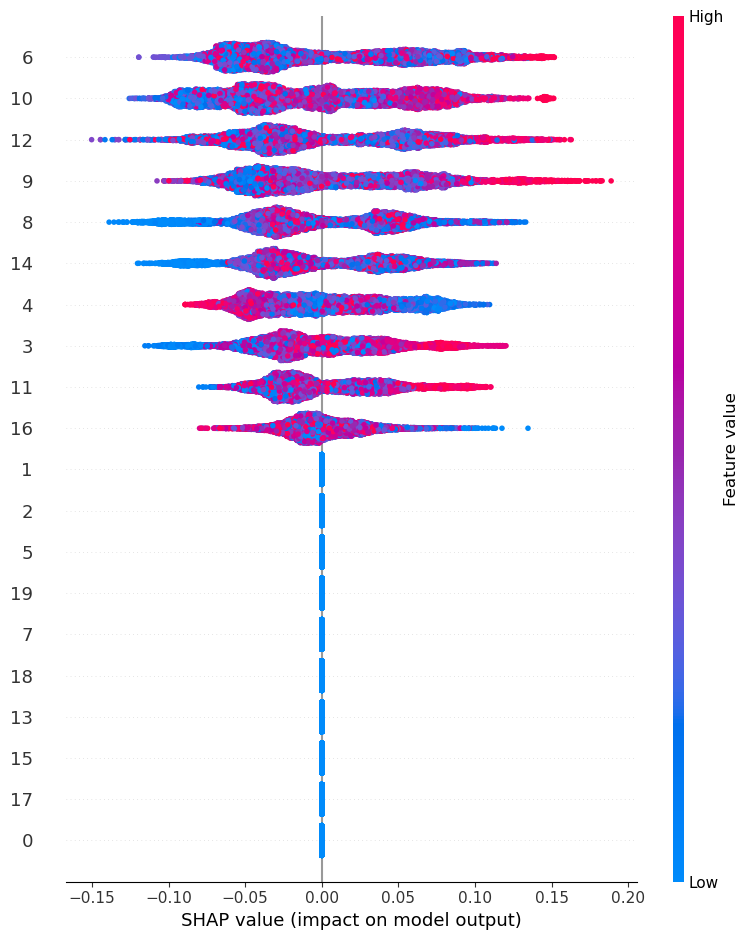

SHAP Summary for Class 1


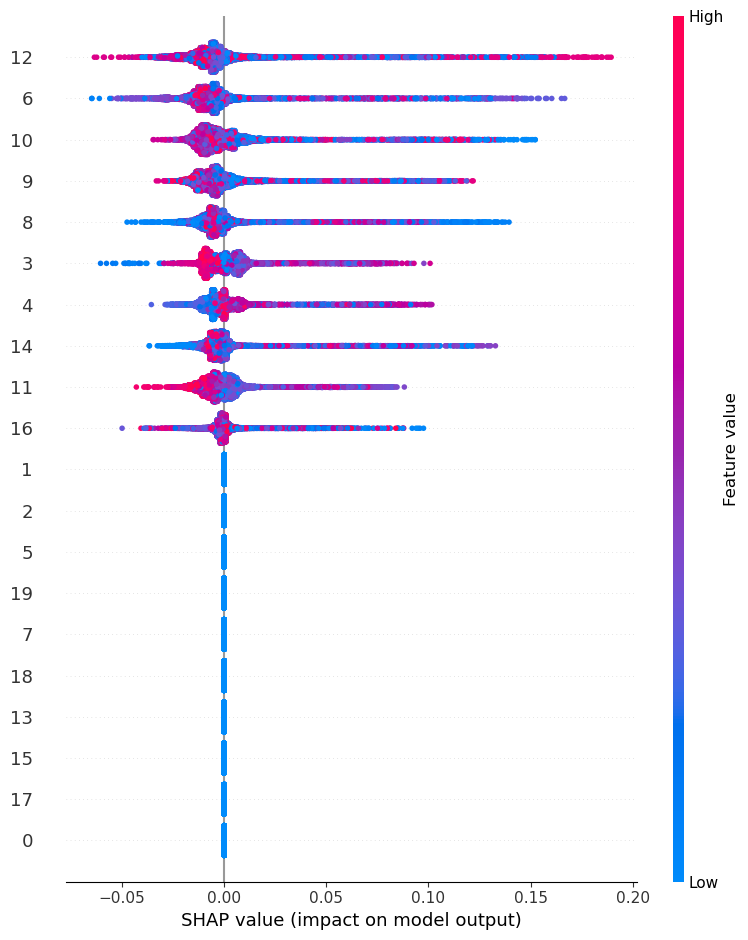

SHAP Summary for Class 2


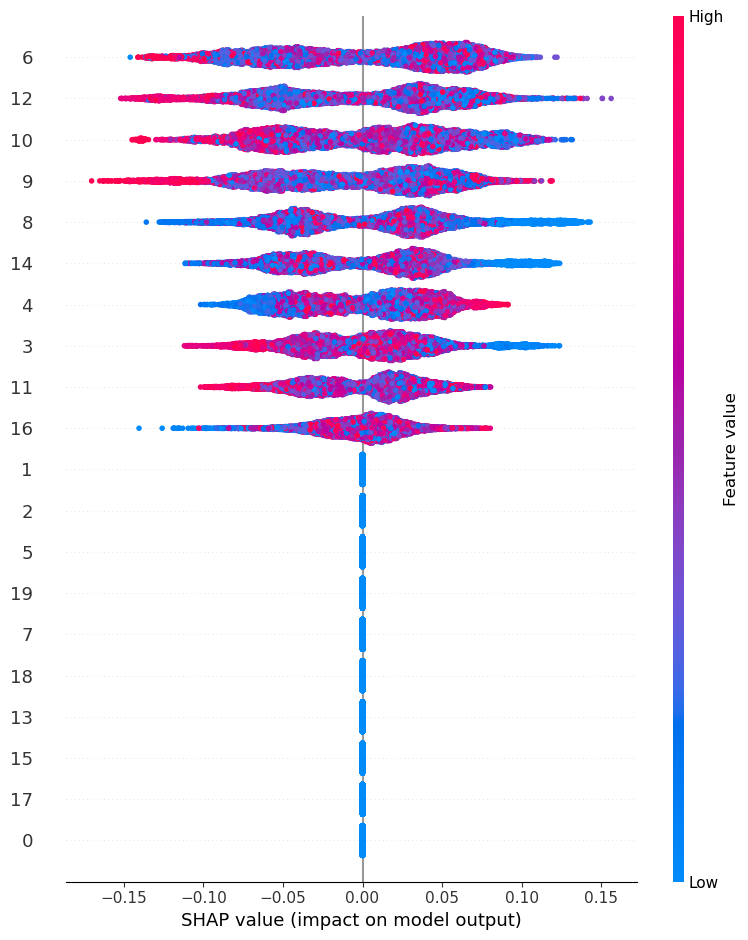

In [22]:
for class_index in range(shap_values.shape[2]):
    print(f"SHAP Summary for Class {class_index}")
    shap.summary_plot(shap_values[:, :, class_index], X_train)


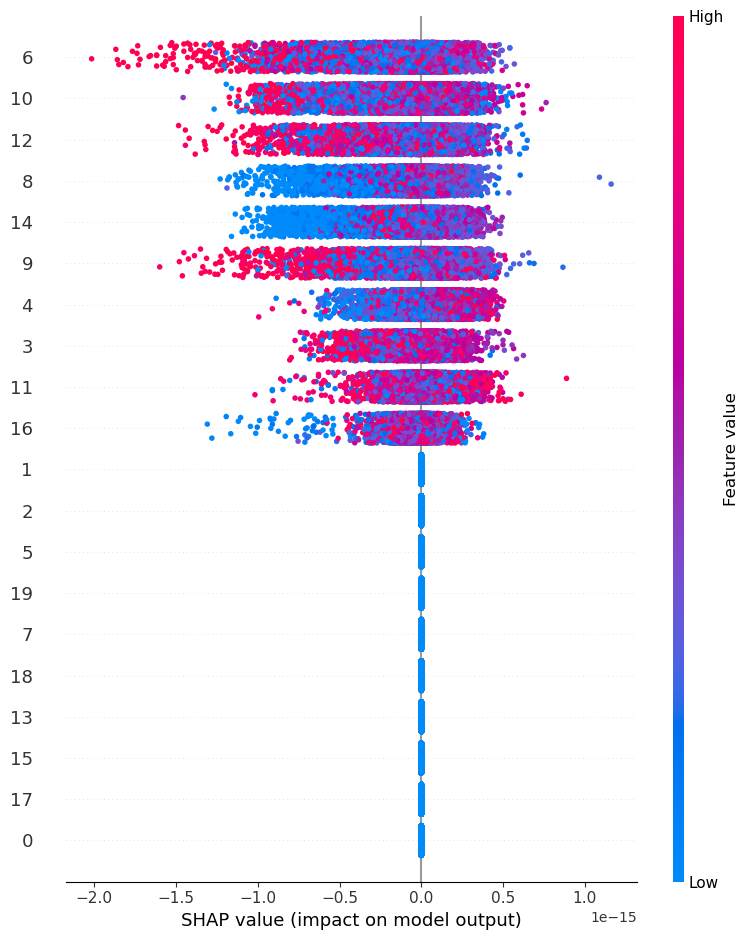

In [23]:
# Aggregate SHAP values across all classes
shap_values_mean = shap_values.mean(axis=2)  # Average over the third dimension

# Plot the SHAP summary for aggregated values
shap.summary_plot(shap_values_mean, X_train)


In [81]:
#xgboost for targets separately
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

models = {}
for target_name, y_target in zip(["Target1", "Target2", "Target3"], [y_train_target1, y_train_target2, y_train_target3]):
    print(f"\nTraining model for {target_name}...")
    
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_target)
    
    models[target_name] = model



Training model for Target1...

Training model for Target2...

Training model for Target3...


In [83]:
predictions = {target: model.predict(X_test) for target, model in models.items()}

In [85]:
decoding_map = {'Target1': {0:'ok', 1:'low', 2:'high'},
'Target2': {0:'ok', 1:'low', 2:'high'},
'Target3': {0:'ok', 1:'low', 2:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]


In [94]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["Target1"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["Target2"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["Target3"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_xgb.csv", index=False)


In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
def create_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')  # Output layer with softmax for classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [110]:
from sklearn.model_selection import train_test_split

# Assuming autoencoded data: X_train_autoencoded, y_train_target1, y_train_target2, y_train_target3
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_autoencoded, y_train_target1, test_size=0.2, stratify=y_train_target1, random_state=42
)


In [111]:
input_dim = X_train_nn.shape[1]  # Number of features
output_dim = len(set(y_train_nn))  # Number of classes

model = create_model(input_dim, output_dim)

# Train the model
history = model.fit(
    X_train_nn, y_train_nn,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_nn, y_val_nn),
    verbose=1
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4837 - loss: 1.4972 - val_accuracy: 0.5708 - val_loss: 0.9700
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5717 - loss: 0.9774 - val_accuracy: 0.5708 - val_loss: 0.9545
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5680 - loss: 0.9655 - val_accuracy: 0.5708 - val_loss: 0.9462
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5710 - loss: 0.9583 - val_accuracy: 0.5696 - val_loss: 0.9447
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5713 - loss: 0.9460 - val_accuracy: 0.5685 - val_loss: 0.9305
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5646 - loss: 0.9483 - val_accuracy: 0.5727 - val_loss: 0.9376
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5730 - loss: 0.9479 - val_accuracy: 0.5693 - val_loss: 0.9312
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5727 - loss: 0.9326 - val_accuracy: 0.

In [112]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val_nn, y_val_nn, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on test data
test_predictions_target1 = model.predict(X_test_autoencoded)
test_predictions_target1_decoded = test_predictions_target1.argmax(axis=1)


Validation Accuracy: 0.6050
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
